# Homework 2 
## Introduzione Varia

### Importing the libraries

In [136]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D, BatchNormalization, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
import tensorflow as tf

# import itertools



### Load Data

In [137]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [138]:
ROOT = '/content/gdrive/MyDrive/Colab Notebooks/Datasets/ASL'

train = pd.read_csv(ROOT+"/sign_mnist_train.csv")
test = pd.read_csv(ROOT+"/sign_mnist_test.csv")

train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [139]:
#load letters samples for futures comparison 
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

letters = load_images_from_folder(ROOT + "/Letters")


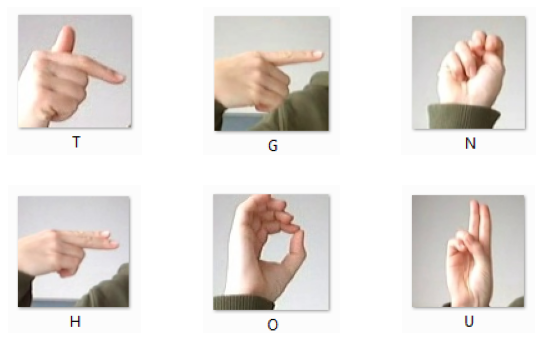

In [140]:
# some samples
fig, ax = plt.subplots(2,3, figsize=(10, 6))
for i in range(2):
    for j in range(3):
        rgb = cv2.cvtColor(letters[i*5+j], cv2.COLOR_BGR2RGB)
        ax[i,j].imshow(rgb)
        ax[i,j].axis('off')
plt.show()

## Data Preprocessing

In [141]:
classes = {i : chr(i+65) for i in sorted(train['label'].unique())}

print(classes)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'}


In [142]:
X_train = train.drop("label", axis=1)
y_train = train["label"]

X_test = test.drop("label", axis=1)
y_test = test["label"]

print("Number of classes: ", len(train['label'].unique()))
print("Number of train images: ", len(X_train))
print("Number of test images: ", len(X_test))
print("Train shape: ", X_train.shape)
print("Test shape: ", X_test.shape)

Number of classes:  24
Number of train images:  27455
Number of test images:  7172
Train shape:  (27455, 784)
Test shape:  (7172, 784)


### Checking for Missing Values

In [143]:
print("Train null value:", sum(X_train.isnull().sum()))
print("Test null value:", sum(X_test.isnull().sum()))

print("Train nan value:", sum(X_train.isna().sum()))
print("Test nan value:", sum(X_test.isna().sum()))

Train null value: 0
Test null value: 0
Train nan value: 0
Test nan value: 0


### Class Imbalance Detection

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


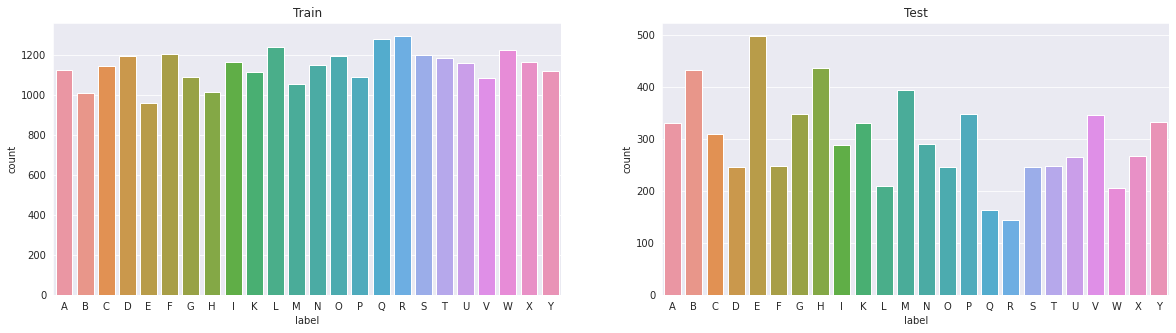

In [144]:
sns.set_style("darkgrid")
fig, ax =plt.subplots(1,2, figsize=(20, 5))
s1 = sns.countplot(y_train, ax=ax[0])
s1.set(title='Train')
s1.set_xticks(range(len(classes))) 
s1.set_xticklabels(classes.values())
s2 = sns.countplot(y_test, ax=ax[1])
s2.set(title='Test')
s2.set_xticks(range(len(classes))) 
s2.set_xticklabels(classes.values())
fig.show()
sns.set_style("whitegrid")

### Data Normalizzation 


In [145]:
X_train = X_train / 255.0
X_test = X_test / 255.0

### Data Reshaping

In [146]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

X_train shape:  (27455, 28, 28, 1)
X_test shape:  (7172, 28, 28, 1)


#### Data Splitting

In [147]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("number of train images: ", len(X_train))
print("number of validation images: ", len(X_val))
print("number of test images: ", len(X_test))

number of train images:  21964
number of validation images:  5491
number of test images:  7172


### Data Augmentation

In [148]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

### Data Visualizzation

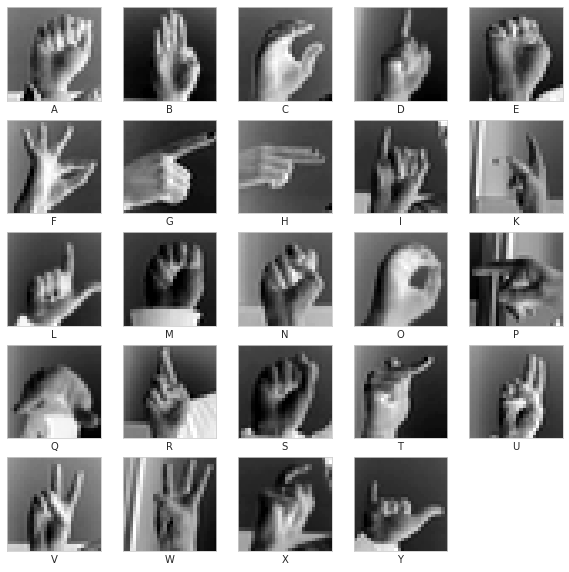

In [149]:
plt.figure(figsize=(10, 10))
letters = np.asarray(list(classes.values()))
for i in range(24):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[np.argmax(y_train[:, i])].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(letters[i])
plt.show()

## Convolutional Neural Network

### Parameters

In [150]:
batch = 32
epochs = 15
opt = 'adam'  #SGD
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

### Model Regularization

In [151]:
from tensorflow import keras
models = []
titles = ['Base', 'Dropout', 'Early Stopping', 'Learning Rate Reduction','Data Augmentation','Batch Normalization']

**1st Model** - No regularization (baseline)

In [152]:
model_base = keras.models.Sequential([
  keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  keras.layers.MaxPooling2D(2, 2),

  keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  keras.layers.MaxPooling2D(2, 2),
  keras.layers.Flatten(),

  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(len(classes), activation='softmax')
])
Wsave = model_base.get_weights()
print(model_base.summary())
models.append(model_base)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 flatten_22 (Flatten)        (None, 1600)              0         
                                                                 
 dense_44 (Dense)            (None, 512)             

**2nd model** - Dropout

In [153]:
model_base = keras.models.Sequential([
  keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  keras.layers.MaxPooling2D(2, 2),
  keras.layers.Dropout(0.2),

  keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  keras.layers.MaxPooling2D(2, 2),
  keras.layers.Flatten(),

  keras.layers.Dropout(0.2),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(len(classes), activation='softmax')
])

print(model_base.summary())
models.append(model_base)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 13, 13, 64)        0         
                                                                 
 conv2d_52 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 flatten_23 (Flatten)        (None, 1600)            

**3rd model** - Early Stopping

In [154]:
model_base = keras.models.Sequential([
  keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  keras.layers.MaxPooling2D(2, 2),

  keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  keras.layers.MaxPooling2D(2, 2),
  keras.layers.Flatten(),

  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(len(classes), activation='softmax')
])

print(model_base.summary())
models.append(model_base)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 flatten_24 (Flatten)        (None, 1600)              0         
                                                                 
 dense_48 (Dense)            (None, 512)             

**4th model** - Learning Rate Reduction

In [155]:
model_base = keras.models.Sequential([
  keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  keras.layers.MaxPooling2D(2, 2),

  keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  keras.layers.MaxPooling2D(2, 2),
  keras.layers.Flatten(),

  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(len(classes), activation='softmax')
])

print(model_base.summary())
models.append(model_base)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 flatten_25 (Flatten)        (None, 1600)              0         
                                                                 
 dense_50 (Dense)            (None, 512)             

**5th model** - Data Augmentation

In [156]:
model_base = keras.models.Sequential([
  keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  keras.layers.MaxPooling2D(2, 2),

  keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  keras.layers.MaxPooling2D(2, 2),
  keras.layers.Flatten(),

  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(len(classes), activation='softmax')
])

print(model_base.summary())
models.append(model_base)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 flatten_26 (Flatten)        (None, 1600)              0         
                                                                 
 dense_52 (Dense)            (None, 512)             

**6th model** - Batch Normalization

In [157]:
model_base = keras.models.Sequential([
  keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  keras.layers.BatchNormalization(),  
  keras.layers.MaxPooling2D(2, 2),

  keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  keras.layers.BatchNormalization(),
  keras.layers.MaxPooling2D(2, 2),
  keras.layers.Flatten(),

  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(len(classes), activation='softmax')
])

print(model_base.summary())
models.append(model_base)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 batch_normalization_18 (Bat  (None, 26, 26, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 batch_normalization_19 (Bat  (None, 11, 11, 64)       256       
 chNormalization)                                                
                                                     

**Final model** 

In [158]:
optimizer = "adam" 

if optimizer == "adam":
  pass
elif optimizer == "adadelta":
  pass
elif optimizer == "sgd":
  # in this case set parameters of the optimizer instead of leaving the default ones
  learning_rate = 0.01
  momentum = 1.0
  optimizer = keras.optimizers.SGD(lr = learning_rate, momentum = momentum)

for m in models:
  m.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Models Fitting

In [159]:
nepochs = 15
batch_size = 32
histories = []
for i,m in enumerate(models):
  print('Training {} model'.format(titles[i]))
  if titles[i] == "Early Stopping": 
    print(titles[i])
    early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')
    histories.append(m.fit(X_train, y_train, batch_size=batch_size, epochs=nepochs, validation_data=(X_test,y_test),callbacks = [early_stopping]))
  elif titles[i] == "Learning Rate Reduction":
    print(titles[i])
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)
    histories.append(m.fit(X_train, y_train, batch_size=batch_size, epochs=nepochs, validation_data=(X_test,y_test),callbacks = [learning_rate_reduction]))
  elif titles[i] == "Augmentation":
    print(titles[i])
    histories.append(m.fit(datagen.flow(X_train,y_train, batch_size = batch) ,epochs = nepochs , validation_data = (X_test, y_test)))
  else:
    histories.append(m.fit(X_train, y_train, batch_size=batch_size, epochs=nepochs, validation_data=(X_test,y_test)))

Training Base model
Epoch 1/15
687/687 [==============================] - 4s 5ms/step - loss: 0.6522 - accuracy: 0.8096 - val_loss: 0.3822 - val_accuracy: 0.8734
Epoch 2/15
687/687 [==============================] - 3s 5ms/step - loss: 0.0187 - accuracy: 0.9973 - val_loss: 0.3500 - val_accuracy: 0.9158
Epoch 3/15
687/687 [==============================] - 5s 7ms/step - loss: 0.0248 - accuracy: 0.9930 - val_loss: 0.4116 - val_accuracy: 0.8918
Epoch 4/15
687/687 [==============================] - 4s 6ms/step - loss: 0.0144 - accuracy: 0.9962 - val_loss: 0.3200 - val_accuracy: 0.9289
Epoch 5/15
687/687 [==============================] - 3s 5ms/step - loss: 2.6397e-04 - accuracy: 1.0000 - val_loss: 0.3306 - val_accuracy: 0.9331
Epoch 6/15
687/687 [==============================] - 3s 5ms/step - loss: 1.4547e-04 - accuracy: 1.0000 - val_loss: 0.3472 - val_accuracy: 0.9339
Epoch 7/15
687/687 [==============================] - 4s 6ms/step - loss: 9.2236e-05 - accuracy: 1.0000 - val_loss: 0.37

#### Accuracy Comparison

6
6


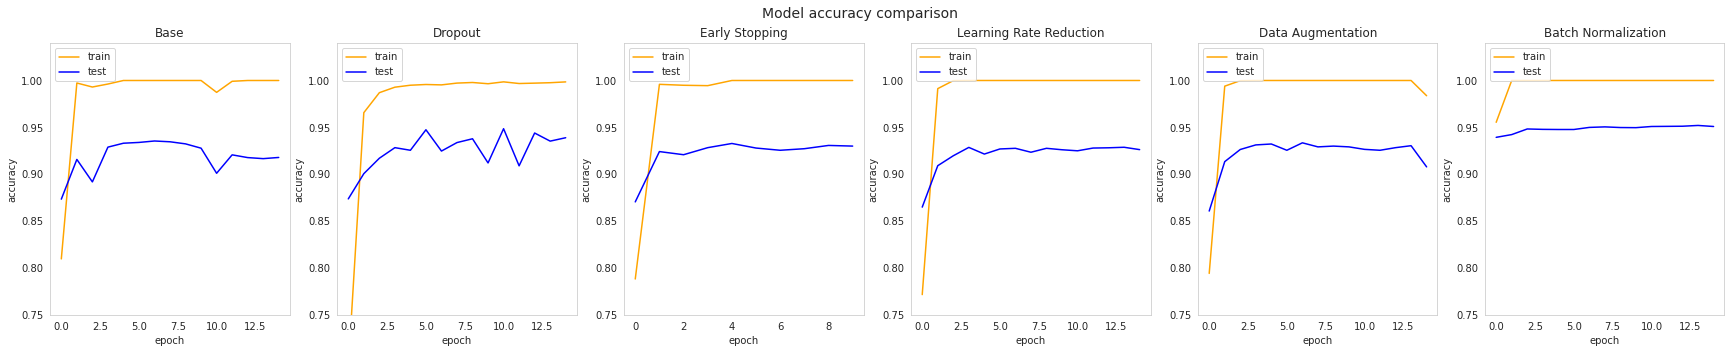

In [160]:
print(len(titles))
print(len(models))
fig=plt.figure(figsize=(30, 5))
for i,h in enumerate(histories):
  plt.subplot(1,len(models),i+1)
  plt.plot(h.history['accuracy'],'orange')
  plt.plot(h.history['val_accuracy'],'b')
  plt.ylim((0.75,1.04))
  plt.title(titles[i])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.grid(False)
  plt.legend(['train', 'test'], loc='upper left')
plt.suptitle('Model accuracy comparison', fontsize=14)
plt.show()

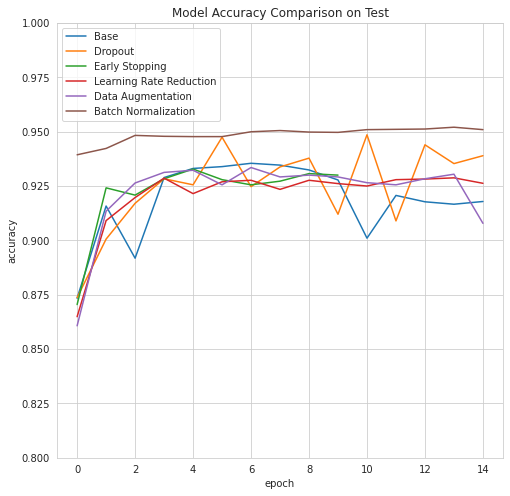

In [161]:
fig=plt.figure(figsize=(8, 8))
for h in histories:
  plt.plot(h.history['val_accuracy'])
  plt.ylim((0.8,1.))
  plt.title('Model Accuracy Comparison on Test')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(titles, loc='upper left')
plt.show()


#### Loss Comparison

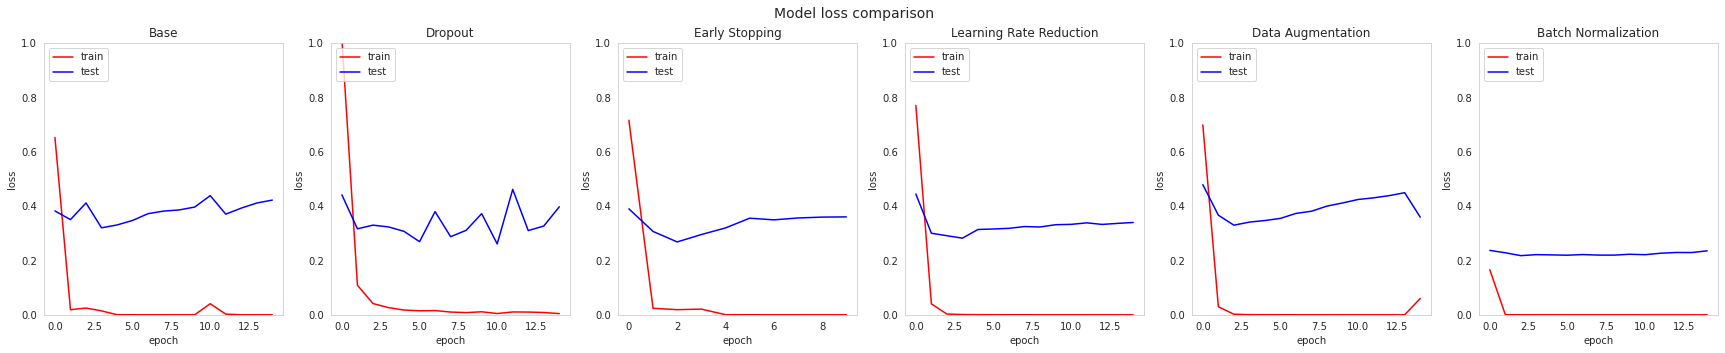

In [162]:
fig=plt.figure(figsize=(30, 5))
for i,h in enumerate(histories):
  plt.subplot(1,len(models),i+1)
  plt.plot(h.history['loss'],'r')
  plt.plot(h.history['val_loss'],'b')
  plt.ylim((0.,1.))
  plt.title(titles[i])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.grid(False)
  plt.legend(['train', 'test'], loc='upper left')
plt.suptitle('Model loss comparison', fontsize=14)
plt.show()

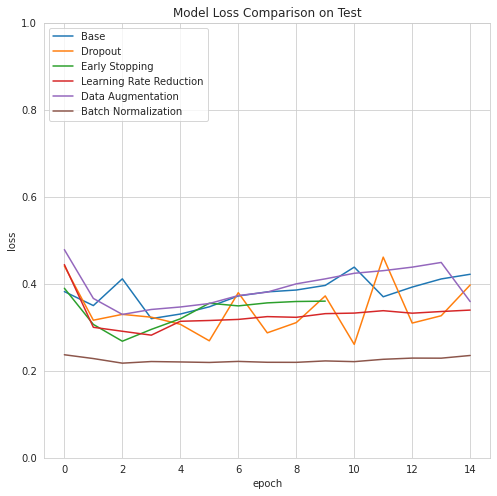

In [163]:
fig=plt.figure(figsize=(8, 8))
for h in histories:
  plt.plot(h.history['val_loss'])
  plt.ylim((0.,1.))
  plt.title('Model Loss Comparison on Test')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(titles, loc='upper left')
plt.show()


### Model Evaluation

In [164]:
model = models[4]
y_pred_sm = model.predict(X_test)
y_pred = np.argmax(y_pred_sm, axis=1)
acc = model.evaluate(X_test, y_test)
print("Accuracy %.3f" %acc[-1])

225/225 [==============================] - 1s 3ms/step - loss: 0.3592 - accuracy: 0.9078
Accuracy 0.908


## Final Model

In [165]:
opt_model = Sequential()

opt_model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
opt_model.add(BatchNormalization())
opt_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

opt_model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
opt_model.add(Dropout(0.2))
opt_model.add(BatchNormalization())
opt_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

opt_model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
opt_model.add(BatchNormalization())
opt_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
opt_model.add(Flatten())

opt_model.add(Dense(units = 512 , activation = 'relu'))
opt_model.add(Dropout(0.3))

opt_model.add(Dense(units = 24 , activation = 'softmax'))

Wsave = opt_model.get_weights()
opt_model.set_weights(Wsave) 

# Compiling and printing the model
opt_model.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
opt_model.summary()

# Training
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1, mode='auto')
opt_history = opt_model.fit(datagen.flow(X_train,y_train, batch_size = batch) ,epochs = epochs , validation_data = (X_test, y_test) , callbacks = [learning_rate_reduction,early_stopping])

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_20 (Bat  (None, 28, 28, 75)       300       
 chNormalization)                                                
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 14, 14, 75)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 14, 14, 50)        33800     
                                                                 
 dropout_16 (Dropout)        (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_21 (Bat  (None, 14, 14, 50)     

### Model Architecture

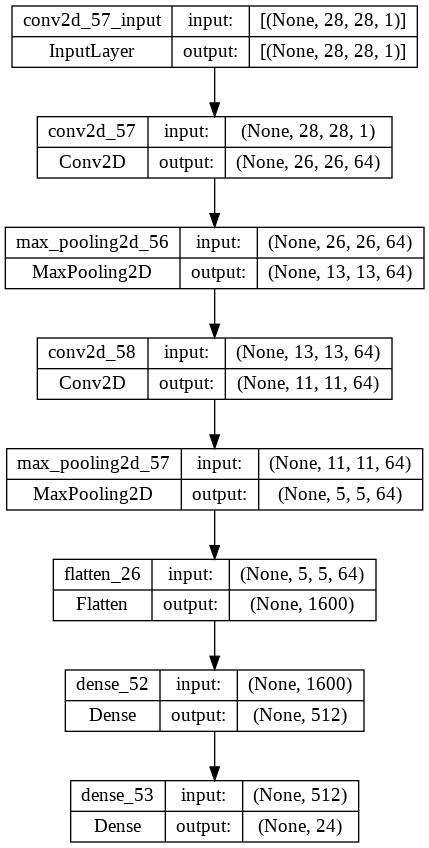

In [166]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

### Model Evaluation

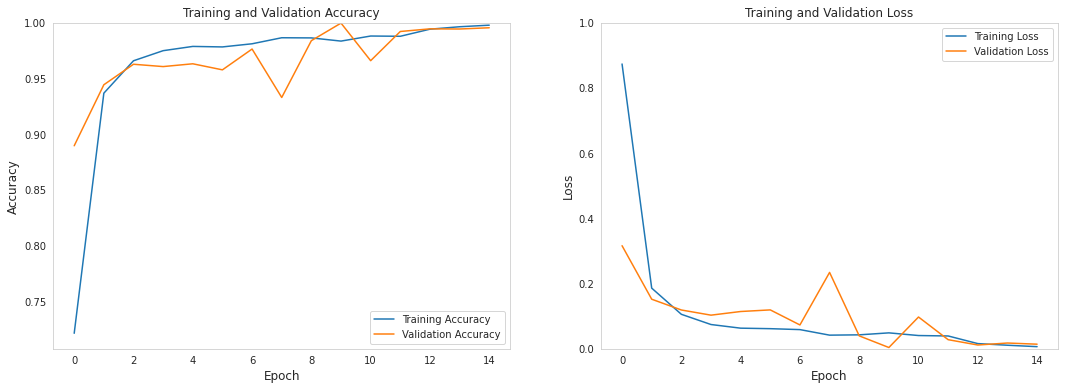

In [167]:
sns.set_style("whitegrid")
#Accuracy

# Metrics
acc = opt_history.history['accuracy']
val_acc = opt_history.history['val_accuracy']
loss = opt_history.history['loss']
val_loss = opt_history.history['val_loss']

# Plotting accuracy
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch', fontsize=12)
plt.grid(False)
# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss', fontsize=12)
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch', fontsize=12)
plt.grid(False)
plt.show()


In [168]:
eval = opt_model.evaluate(X_test,y_test)[1]

print("Accuracy of the model is - " , eval)

225/225 [==============================] - 1s 3ms/step - loss: 0.0141 - accuracy: 0.9954
Accuracy of the model is -  0.995398759841919


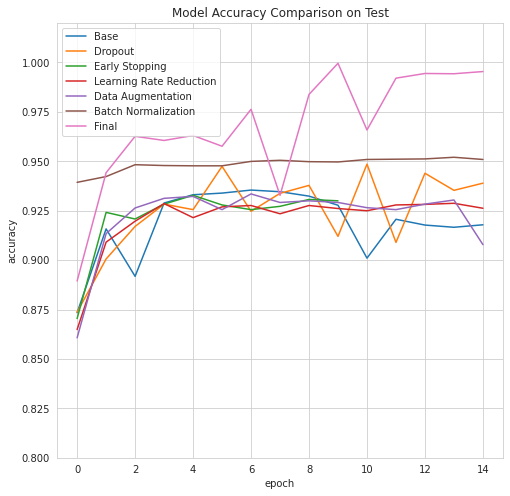

In [169]:
fig=plt.figure(figsize=(8, 8))
histories.append(opt_history)
titles.append('Final')
for h in histories:
  plt.plot(h.history['val_accuracy'])
  plt.ylim((0.8,1.02))
  plt.title('Model Accuracy Comparison on Test')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(titles, loc='upper left')
plt.show()

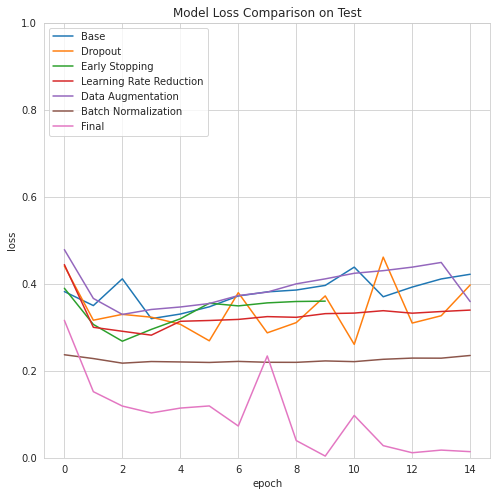

In [170]:
fig=plt.figure(figsize=(8, 8))
for h in histories:
  plt.plot(h.history['val_loss'])
  plt.ylim((0.,1.))
  plt.title('Model Loss Comparison on Test')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(titles, loc='upper left')
plt.show()

### Model Prediction

In [171]:
# Predict the values from the validation dataset
y_pred = opt_model.predict(X_val)
# Convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred,axis = 1)
# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1)

print(classification_report(y_true, y_pred_classes,target_names = list(classes.values())))

172/172 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       221
           B       1.00      1.00      1.00       188
           C       1.00      1.00      1.00       220
           D       1.00      1.00      1.00       256
           E       1.00      1.00      1.00       202
           F       1.00      1.00      1.00       242
           G       1.00      1.00      1.00       221
           H       1.00      1.00      1.00       205
           I       1.00      1.00      1.00       219
           K       1.00      1.00      1.00       219
           L       1.00      1.00      1.00       268
           M       1.00      1.00      1.00       232
           N       1.00      1.00      1.00       209
           O       1.00      1.00      1.00       219
           P       1.00      1.00      1.00       202
           Q       1.00      1.00      1.00       291
           R       1.00   

### Confusion Matrix

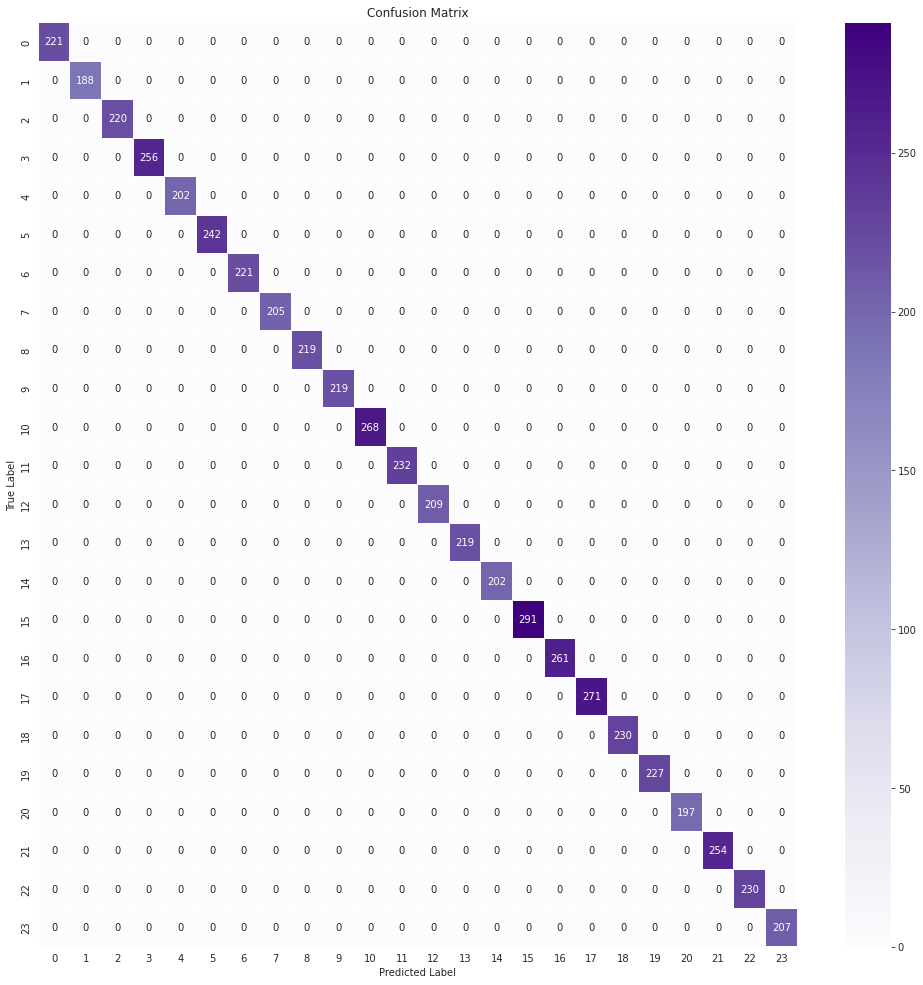

In [172]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

f,ax = plt.subplots(figsize=(17, 17))

sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Purples", fmt= '.0f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()